In [96]:
%matplotlib inline
import os, re
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

systems = glob('../tmp/analyses/prod/*')

rho = 1.0753e3
NA = 6.022e23
MW = (60.052 + 82.10) * 1e-3
q = 1.602176634e-19
T = 340
kB = 1.380649e-23
ne_fac = rho / MW * q**2 / (kB * T) * NA * 10 * 1e-10
gk_fac = rho / MW * q**2 / (kB * T) * NA * 10 / 32 * 1e-10
d = lambda msd, idx: msd[1000, idx]/msd[1000, 0]/6*100

result = {}
for sys in sorted(systems):
    name = os.path.basename(sys)
    msd = np.load(f"{sys}/msd-0-5ns/msd.npy")
    pmsd = np.load(f"{sys}/msd-0-5ns/pmsd.npy")
    d_all=[d(msd,1), d(msd,2), d(msd,3), d(pmsd, 1)]
    frac = float(re.search('\d+k-(.*)-\d+', name).group(1))
    if frac not in result:
        result[frac]=[d_all]
    else:
        result[frac].append(d_all)

conc = np.array(sorted(result.keys()))
result = np.array([result[c] for c in conc])
sigma = result[:,:,3]*gk_fac
delta = 1-sigma/(result[:,:,1]+ result[:,:,0])*ne_fac

In [135]:
np.average(sigma.mean(axis=1),weights=np.array(ratio_conc)[which])

8.583456370264242

In [124]:
sigma = result[:,:,3]*gk_fac
delta = 1-result[:,:,3]*gk_fac/((result[:,:,1]+result[:,:,0])*ne_fac)


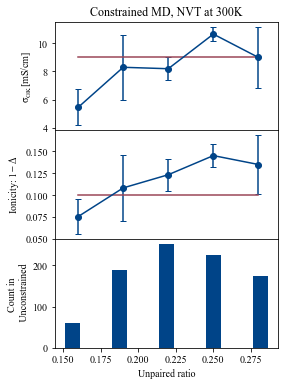

In [130]:
f, axs = plt.subplots(3,1, figsize=[4,6], sharex=True,gridspec_kw={'hspace':0})
axs[0].errorbar(conc, sigma.mean(axis=1), sigma.std(axis=1), marker='o')
axs[1].errorbar(conc, 1-delta.mean(axis=1), delta.std(axis=1), marker='o')
axs[2].bar(np.array(ratio_conc)[which], ratio_cnt[which], width=0.01)
axs[0].plot([conc[0],conc[-1]],[9,9])
axs[1].plot([conc[0],conc[-1]],[0.1,0.1])
axs[0].set_ylabel('$\sigma_{GK}[mS/cm]$')
axs[1].set_ylabel('Ionicity: $1-\Delta$')
axs[2].set_ylabel('Count in \n Unconstrained')
axs[2].set_xlabel('Unpaired ratio')
axs[0].set_title('Constrained MD, NVT at 300K')
plt.savefig('constrained.pdf')

In [80]:
np.array(ratio_conc)[which]

array([0.15625, 0.1875 , 0.21875, 0.25   , 0.28125])

In [ ]:
from ase.io import read, write
from lib.topo import mkconst
lastns = read('../exp/scan/prod/gen49/nvt-300k-5ns-0/a16b16i16-r1.08/asemd.traj', index='40001::10')
ratio_cnt = {}
for i, atoms in enumerate(lastns):
    atoms, ratio = mkconst(atoms)
    if ratio in ratio_cnt:
        ratio_cnt[ratio]+=1
    else:
        ratio_cnt[ratio]=1
ratio_conc = sorted(ratio_cnt.keys())
ratio_cnt = np.array([ratio_cnt[c] for c in sorted(ratio_cnt.keys())])
which = (0.15<np.array(ratio_conc)) & (np.array(ratio_conc)<0.3)

In [68]:
for k,v in sigma.items():
    print(f'temperature {k}, '
          f'H {np.mean(v[3]):.2f}({np.std(v[3]):.2f}), '
          f'O {np.mean(v[4]):.2f}({np.std(v[4]):.2f}), '
          f'N {np.mean(v[5]):.2f}({np.std(v[5]):.2f}), '
          f'GK {np.mean(v[2]):.2f}({np.std(v[2]):.2f}), '
          f'Dleta {np.mean(v[1]):.2f}({np.std(v[1]):.2f})')

temperature 340, H 0.10(0.04), O 0.12(0.04), N 0.12(0.06), GK 0.70(0.38), Dleta 0.87(0.06)
temperature 380, H 0.43(0.12), O 0.46(0.12), N 0.48(0.14), GK 1.97(1.32), Dleta 0.91(0.06)
temperature 450, H 1.79(0.33), O 1.90(0.34), N 1.95(0.23), GK 14.34(13.56), Dleta 0.85(0.16)


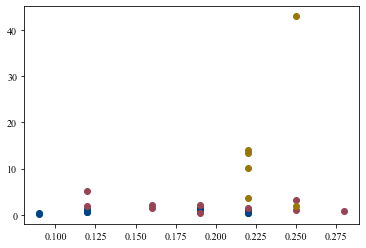

In [69]:
plt.scatter(sigma[340][0], sigma[340][2])
plt.scatter(sigma[380][0], sigma[380][2])
plt.scatter(sigma[450][0], sigma[450][2])
